In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import argparse
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl

import sys
sys.path.append('../..')
from data.dataloader import get_covid19india_api_data
from main.seir.fitting import single_fitting_cycle, get_variable_param_ranges
from main.seir.fitting import get_all_district_data, data_setup, run_cycle
from main.seir.forecast import create_all_csvs, write_csv, plot_forecast

In [76]:
def backtesting(df_district, df_district_raw_data, increment=5, future_days=10, optimize_runs=3, max_evals=100, train_period=7, val_period=7):
    runtime_s = time.time()
    start = pd.to_datetime(df_district['date']).min()
    end = pd.to_datetime(df_district['date']).max()
    print(start, end)
    n_days = (end - start).days + 1 - future_days
    # model = model.generate()
    results = {}
    seed = datetime.today().timestamp()
    for run_day in range(train_period + val_period + 1, n_days, increment):
        end_date = pd.to_datetime(df_district['date'], format='%Y-%m-%d').loc[run_day]
        print ("\rbacktesting for", end_date, end="")

        #  TRUNCATE DATA
        df_district_incr = df_district[pd.to_datetime(df_district['date'], format='%Y-%m-%d') <= end_date]
        df_district_raw_data_incr = df_district_raw_data[pd.to_datetime(df_district_raw_data['date'], format='%Y-%m-%d') <= end_date]
        
        df_district_incr, df_district_raw_data_incr, df_train, df_val, df_true_fitting, df_train_nora, df_val_nora = \
            data_setup(df_district_incr, df_district_raw_data_incr, pre_lockdown, train_on_val, val_period)
        
        # FIT/PREDICT
        res = run_cycle(
            state, district, df_district_incr, df_district_raw_data_incr, df_train, df_val, df_train_nora, df_val_nora, data_from_tracker,
            train_period=train_period, train_on_val=train_on_val, num_evals=num_evals, N=N, 
            which_compartments=which_compartments, initialisation=initialisation
        )

        results[end_date] = {
            'n_days': n_days,
            'seed': seed,
            'results': res,
        }
    runtime = time.time() - runtime_s
    print (runtime)
    out = {
        'results': results,
        'df_district': df_district,
        'future_days': future_days,
        'runtime': runtime,
    }
    return out

In [62]:
dataframes = get_covid19india_api_data()


In [88]:
state, district = 'Maharashtra', 'Pune'
fit = 'm1' # 'm1' or 'm2'
data_from_tracker=False

In [89]:
train_period = 7
N = 1e7
pre_lockdown = False
initialisation = 'intermediate'
which_compartments = ['hospitalised', 'total_infected', 'deceased', 'recovered']

val_period = 7 if fit is 'm1' else 0
train_on_val = False if fit is 'm1' else True
num_evals = 700 if data_from_tracker else 1000

if district == 'Mumbai':
    data_format = 'old'
    filepath = '../../data/data/official-mumbai.csv'
elif district == 'Pune':
    data_format = 'new'
    filepath = '../../data/data/official-pune-21-05-20.csv'

In [90]:
df_district, df_district_raw_data = get_all_district_data(dataframes, state, district, 
                data_from_tracker, data_format, filepath)

2020-04-24 00:00:00 2020-05-27 00:00:00
backtesting for 2020-05-09 00:00:00splitting data ..
splitting data ..
100%|██████████| 700/700 [03:05<00:00,  3.78trial/s, best loss: 2.655215101609404]
best parameters
 {'E_hosp_ratio': 0.09278745791344269, 'I_hosp_ratio': 0.29067927308809405, 'P_fatal': 0.1457021400581011, 'P_severe': 0.7172859404595637, 'T_inc': 4.4545133460850925, 'T_inf': 3.0580803089525253, 'T_recov_severe': 49.82800110771167, 'lockdown_R0': 1.3569844173768633}
backtesting for 2020-05-10 00:00:00splitting data ..
splitting data ..
100%|██████████| 700/700 [02:53<00:00,  4.04trial/s, best loss: 5.155794832158644]
best parameters
 {'E_hosp_ratio': 0.7167287296617109, 'I_hosp_ratio': 0.15177903636158901, 'P_fatal': 0.12462561152590615, 'P_severe': 0.6574882822090298, 'T_inc': 4.78181473868373, 'T_inf': 3.5866875215989067, 'T_recov_severe': 54.60484176631922, 'lockdown_R0': 1.4489720179024443}
backtesting for 2020-05-11 00:00:00splitting data ..
splitting data ..
100%|████████

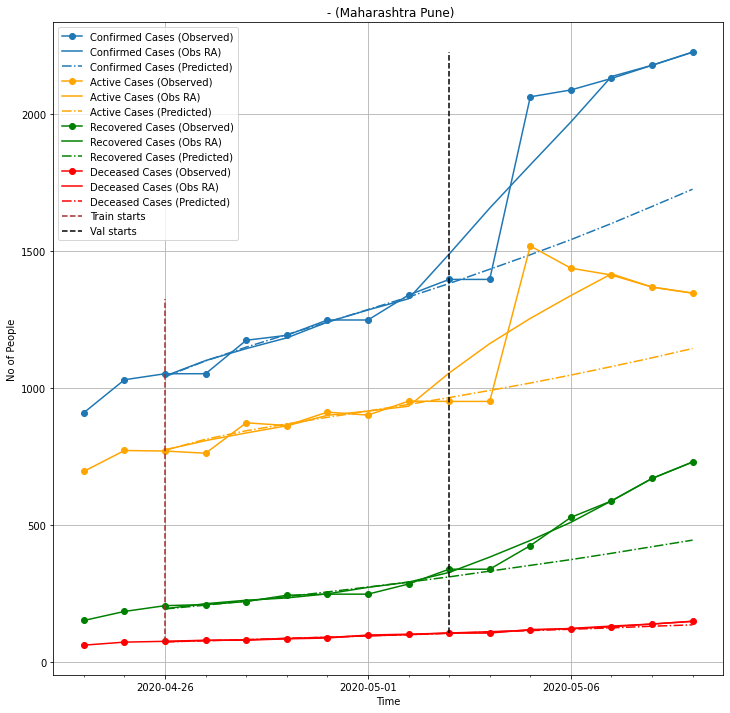

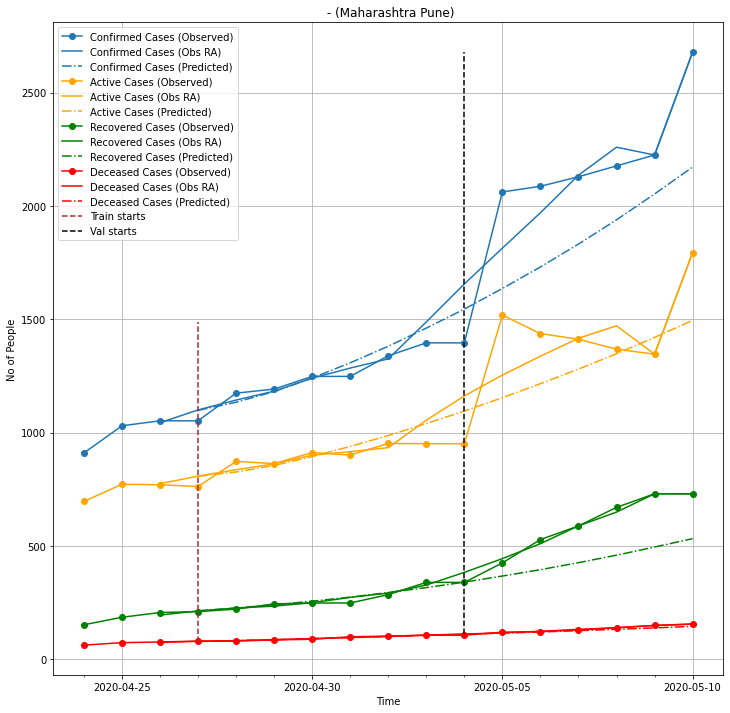

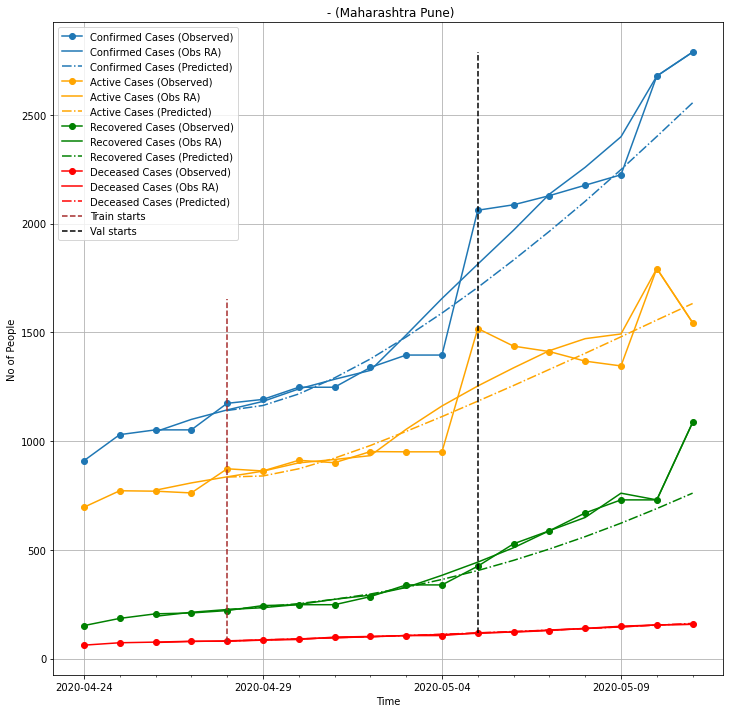

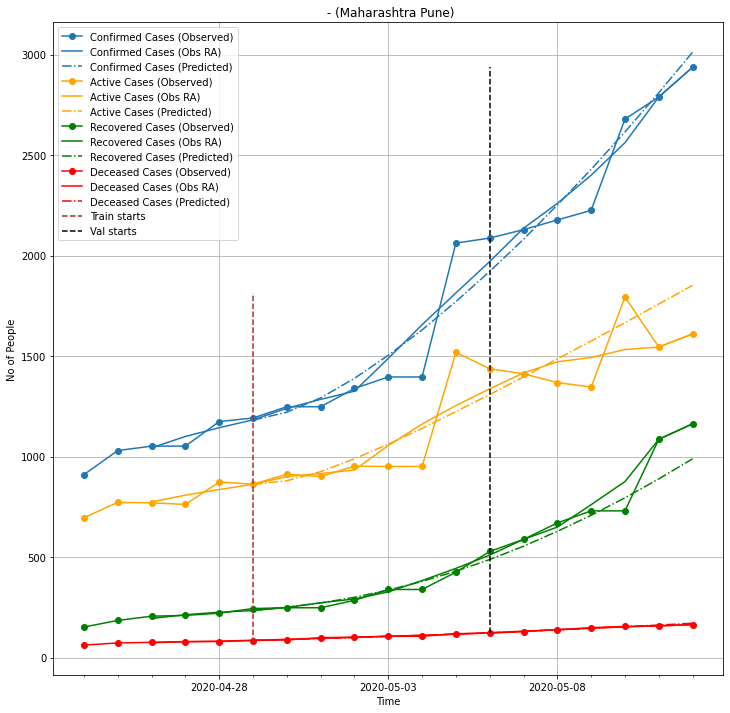

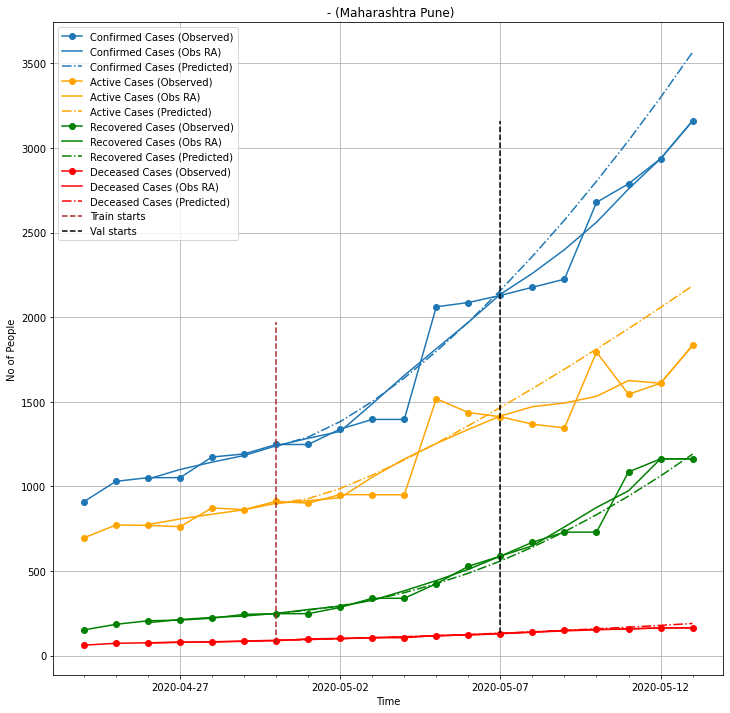

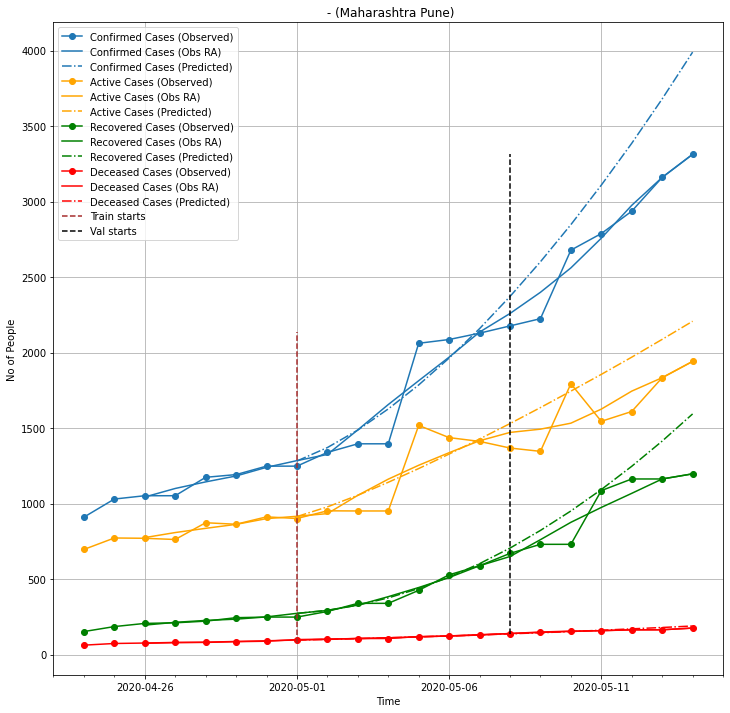

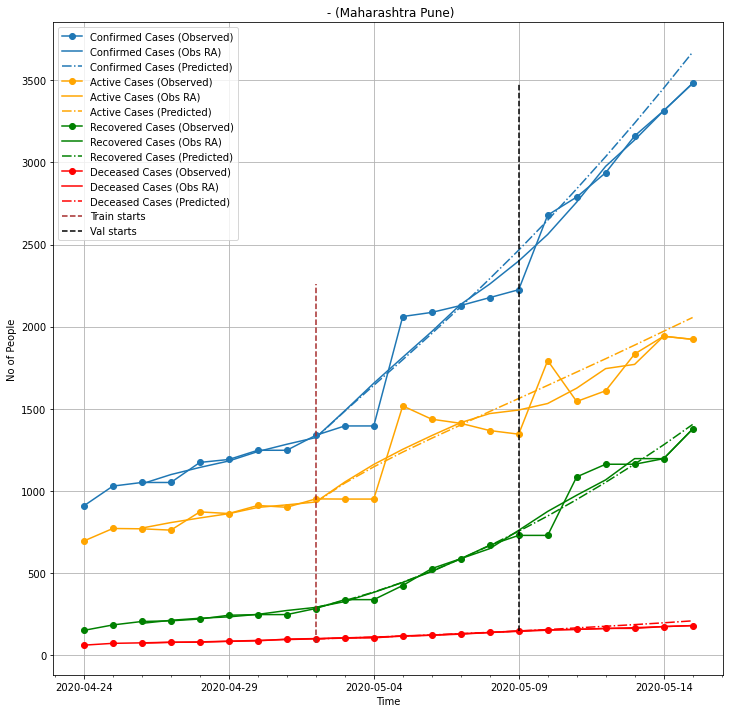

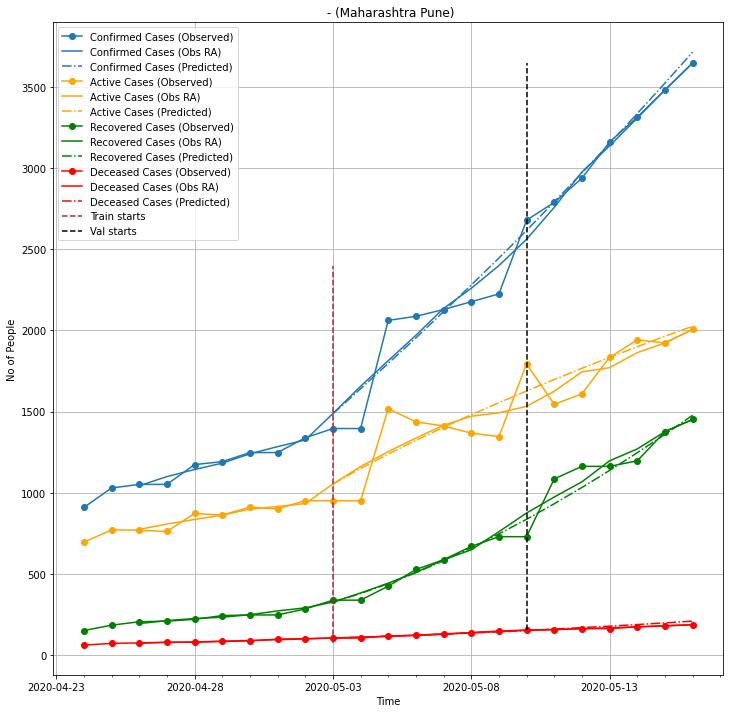

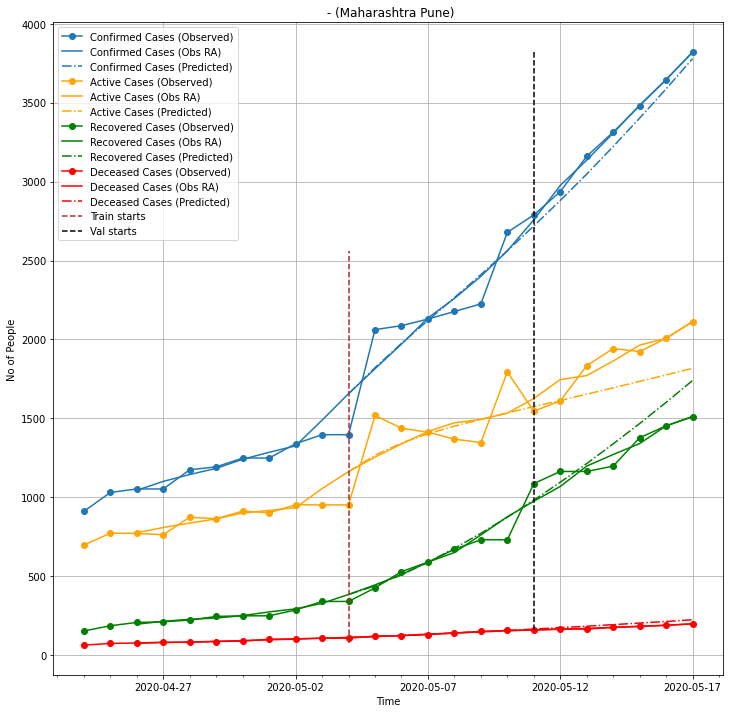

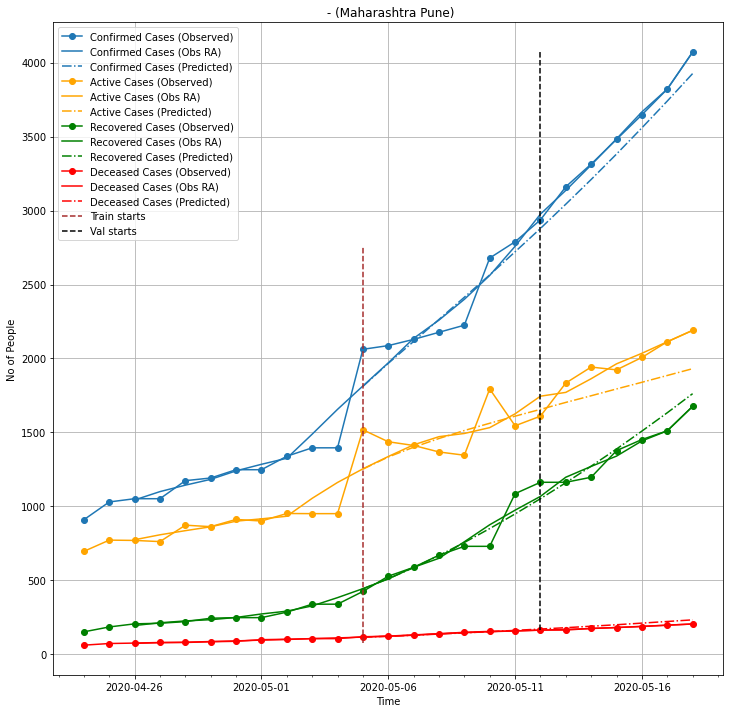

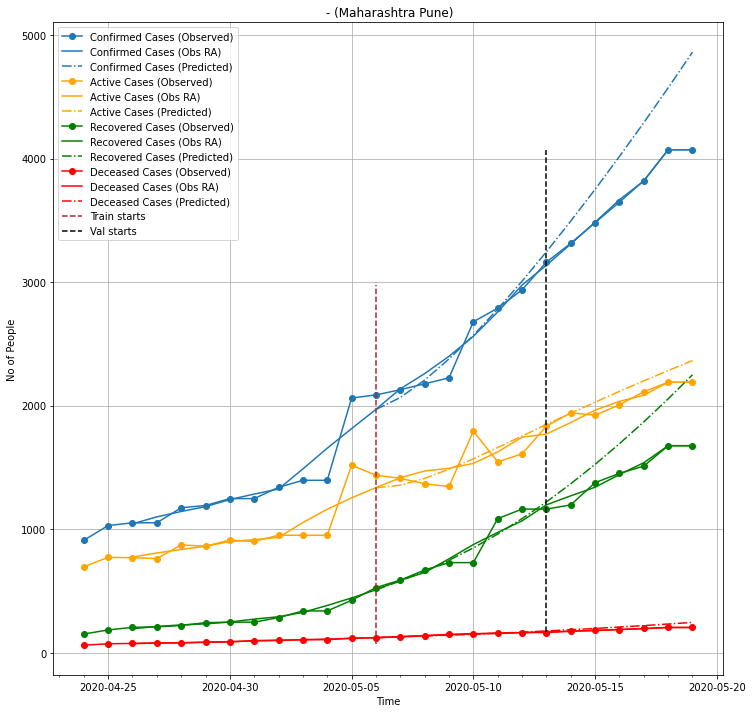

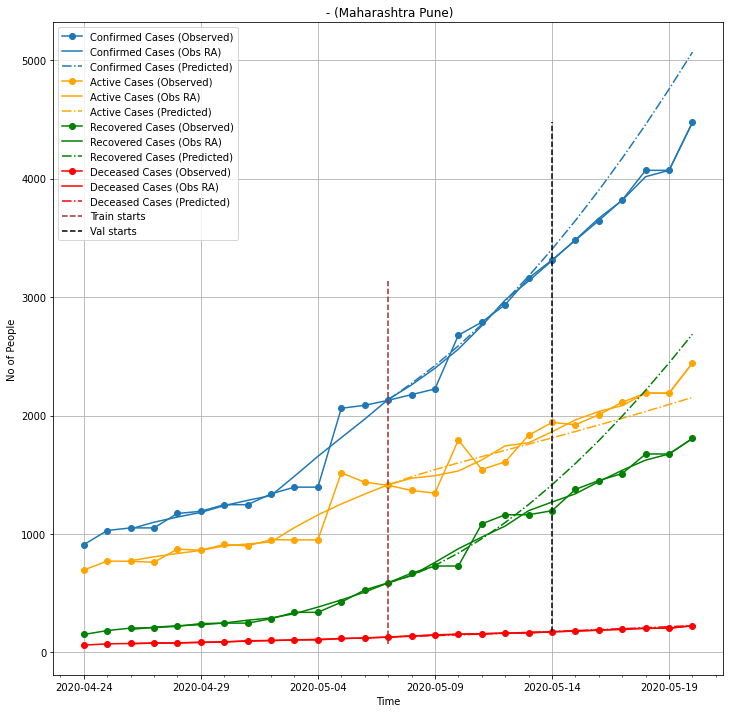

In [91]:
out = backtesting(df_district, df_district_raw_data, future_days=7, increment=1, train_period=train_period, val_period=val_period)

In [94]:
out['results'].keys()

dict_keys([Timestamp('2020-05-09 00:00:00'), Timestamp('2020-05-10 00:00:00'), Timestamp('2020-05-11 00:00:00'), Timestamp('2020-05-12 00:00:00'), Timestamp('2020-05-13 00:00:00'), Timestamp('2020-05-14 00:00:00'), Timestamp('2020-05-15 00:00:00'), Timestamp('2020-05-16 00:00:00'), Timestamp('2020-05-17 00:00:00'), Timestamp('2020-05-18 00:00:00'), Timestamp('2020-05-19 00:00:00'), Timestamp('2020-05-20 00:00:00')])

In [95]:
for run in out['results'].keys():
    print(out['results'][run]['results']['df_loss'])
    # print(out['results'][run]['results']['df_prediction'])

train      val
hospitalised    2.26135  23.3909
total_infected  1.69796  24.4137
deceased        2.63234  4.08562
recovered       3.59248  34.8551
                  train      val
hospitalised      4.338  14.2678
total_infected  3.04138  16.6366
deceased        2.37508  4.47612
recovered       4.03447  31.2085
                  train      val
hospitalised    5.77737  11.5735
total_infected  4.53768   9.7543
deceased        2.16661  1.52458
recovered       4.24211  17.6468
                  train      val
hospitalised     8.7507  9.47444
total_infected  6.87373  4.05166
deceased        2.25849  1.87587
recovered       4.55743  10.2941
                  train      val
hospitalised    9.05303  13.7843
total_infected  7.13576  8.27037
deceased        2.43391  4.99402
recovered       4.56107   7.0537
                  train      val
hospitalised    9.01904  12.9093
total_infected  6.91565  11.9059
deceased        1.87204  4.01226
recovered       4.68845  12.7756
                  train     

In [96]:
def create_plots(results, df_train, df_val, df_train_nora, df_val_nora, train_period, state, district, 
                 which_compartments=['hospitalised', 'total_infected'], description=''):
    # Create plots
    if isinstance(df_val, pd.DataFrame):
        df_true_plotting_rolling = pd.concat([df_train, df_val], ignore_index=True)
        df_true_plotting = pd.concat([df_train_nora, df_val_nora], ignore_index=True)
    else:
        df_true_plotting_rolling = df_train
        df_true_plotting = df_train_nora
    
    # import pdb; pdb.set_trace()
    if 'total_infected' in which_compartments:
        plt.plot(df_true_plotting['date'], df_true_plotting['total_infected'],
                '-o', color='C0', label='Confirmed Cases', markersize=3)
        plt.plot(df_true_plotting_rolling['date'], df_true_plotting_rolling['total_infected'],
                '-', color='C0', linewidth=.25)
    if 'hospitalised' in which_compartments:
        plt.plot(df_true_plotting['date'], df_true_plotting['hospitalised'],
                '-o', color='orange', label='Active Cases', markersize=3)
        plt.plot(df_true_plotting_rolling['date'], df_true_plotting_rolling['hospitalised'],
                '-', color='orange', linewidth=.25)
    if 'recovered' in which_compartments:
        plt.plot(df_true_plotting['date'], df_true_plotting['recovered'],
                '-o', color='green', label='Recovered Cases', markersize=3)
        plt.plot(df_true_plotting_rolling['date'], df_true_plotting_rolling['recovered'],
                '-', color='green', linewidth=.25)
    if 'deceased' in which_compartments:
        plt.plot(df_true_plotting['date'], df_true_plotting['deceased'],
                '-o', color='red', label='Deceased Cases', markersize=3)
        plt.plot(df_true_plotting_rolling['date'], df_true_plotting_rolling['deceased'],
                '-', color='red', linewidth=.25)

    for i, run in enumerate(results.keys()):
        color_idx = i/len(results.keys())
        df_pred_run = results[run]['results']['df_prediction']
        df_predicted_plotting_run = df_pred_run.loc[df_pred_run['date'].isin(
            df_true_plotting['date']), ['date', 'hospitalised', 'total_infected', 'deceased', 'recovered']]
        if 'total_infected' in which_compartments:
            cmap = mpl.cm.get_cmap('winter')
            color = cmap(color_idx)
            plt.plot(df_predicted_plotting_run['date'], df_predicted_plotting_run['total_infected'],
                    '-.', color=cmap(color_idx))
        if 'hospitalised' in which_compartments:
            cmap = mpl.cm.get_cmap('Wistia')
            plt.plot(df_predicted_plotting_run['date'], df_predicted_plotting_run['hospitalised'],
                    '-.', color=cmap(color_idx))
        if 'recovered' in which_compartments:
            cmap = mpl.cm.get_cmap('summer')
            plt.plot(df_predicted_plotting_run['date'], df_predicted_plotting_run['recovered'],
                    '-.', color=cmap(color_idx))
        if 'deceased' in which_compartments:
            cmap = mpl.cm.get_cmap('autumn')
            plt.plot(df_predicted_plotting_run['date'], df_predicted_plotting_run['deceased'],
                    '-.', color=cmap(color_idx))
    
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
    plt.ylabel('No of People')
    plt.legend()
    plt.title('{} - ({} {})'.format(description, state, district))
    plt.grid()

In [97]:
df_district, df_district_raw_data, df_train, df_val, df_true_fitting, df_train_nora, df_val_nora = \
            data_setup(df_district, df_district_raw_data, pre_lockdown, train_on_val, val_period)

splitting data ..
splitting data ..


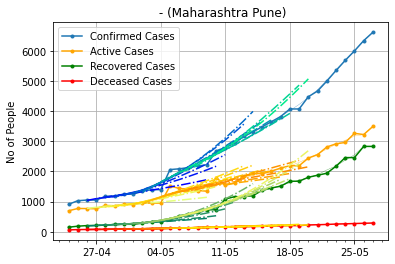

In [98]:
create_plots(out['results'], df_train, df_val, df_train_nora, df_val_nora, train_period, state, district, 
                 which_compartments=which_compartments)

In [99]:
for run in out['results'].keys():
    print(out['results'][run]['results']['df_loss'].loc['deceased','val'])

4.085623697627981
4.476120010495679
1.5245848339853862
1.8758723840067855
4.994023075799709
4.012260274983411
7.486938002509872
6.096451756415265
8.711587489560625
9.222299365620135
10.152828410304693
2.31293371087161


In [100]:
def plot_backtesting_errors(state, district, results, compartment='total_infected',description=''):
    plt.title('{} - ({} {})'.format(description, state, district))
    # plot error
    dates = [run_day for run_day in results.keys()]
    errs = [results[run_day]['results']['df_loss'].loc[compartment,'val'] for run_day in results.keys()]
    plt.plot(dates, errs, ls='-', c='crimson',
        label='mape')

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
    plt.ylabel('MAPE')
    plt.legend()
    plt.grid()
    return

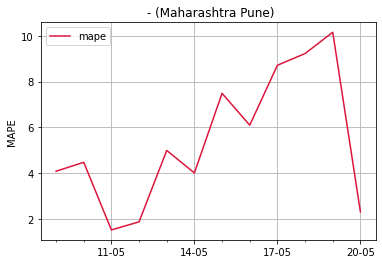

In [101]:
plot_backtesting_errors(state, district, out['results'], compartment='deceased')